## Modeling Overview

In this module, we assess the effectiveness of three supervised learning paradigms for predicting helpful vote counts:

1. **Ensemble Methods (XGBoost)**  
   We start with a gradient‑boosted decision tree model to capture non‑linear interactions and high‑order feature importance.

2. **Simple Baselines (K‑Nearest Neighbors)**  
   As a lightweight comparator, we use KNN to gauge how much structure can be exploited by distance‑based approaches.

3. **Neural Networks (Multi‑Layer Perceptron with L1 Regularization)**  
   Finally, we train a feed‑forward network with L1 penalty to encourage sparsity and test its ability to generalize.

Throughout, we apply feature screening and dimensionality reduction—especially on the XGBoost model’s most important variables—to streamline the input space and boost overall performance.

All code was executed on rented servers at https://featurize.cn/vm/mine.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import (
    r2_score,
    mean_squared_error,
    mean_absolute_error,
    median_absolute_error,
    explained_variance_score
)
import matplotlib.pyplot as plt

In [8]:
#assume you have downloaded all the data we get in 'data_processing' part.
X = pd.read_csv('Total_X.csv',index_col=0)
Y = pd.read_csv('Total_Y.csv',index_col=0)

In [9]:
for index,i in enumerate(X.isnull().sum()):
    if i!=0:
        print(i,X.isnull().sum().index[index])
non_numeric_cols = X.select_dtypes(exclude=['number']).columns
print(non_numeric_cols)

X['verified_purchase']=X['verified_purchase'].astype('int')

X_train, X_test, y_train, y_test = train_test_split(
    X,Y,
    random_state=0,
    test_size=0.2,
    shuffle = True)
print(f"X_train: {X_train.shape}, X_test: {X_test.shape}")
print(f"y_train: {y_train.shape}, y_test: {y_test.shape}")

128887 whether_discontinued_review_count
128887 whether_discontinued_average_rating
Index(['verified_purchase'], dtype='object')
X_train: (217172, 152), X_test: (54293, 152)
y_train: (217172, 1), y_test: (54293, 1)


## RegressionEvaluator Utility

This `RegressionEvaluator` class provides a one‑stop evaluation pipeline for regression models. It converts inputs to NumPy arrays, computes a suite of performance metrics (`R², MSE, RMSE, MAE, MedAE, MAPE, Explained Variance`), and offers both a concise summary and visual diagnostics (residual histogram, actual vs. predicted scatter), along with a table of the largest prediction errors.


In [15]:
class RegressionEvaluator:
    """
    A one‐stop regression evaluation pipeline.

    Attributes:
        y_test (np.ndarray): True target values.
        y_pred (np.ndarray): Predicted target values.
        residuals (np.ndarray): Errors = y_test - y_pred.
    """

    def __init__(self, y_test, y_pred):

        #handle torch form
        if isinstance(y_test, torch.Tensor):
            y_test = y_test.detach().cpu().numpy()
        if isinstance(y_pred, torch.Tensor):
            y_pred = y_pred.detach().cpu().numpy()
        # force to numpy array and flatten to 1D
        self.y_test = np.asarray(y_test).ravel()
        self.y_pred = np.asarray(y_pred).ravel()

        # sanity checks
        assert self.y_test.ndim == 1 and self.y_pred.ndim == 1, \
            f"y_test and y_pred must be 1D arrays, got {self.y_test.shape} & {self.y_pred.shape}"
        assert self.y_test.shape == self.y_pred.shape, \
            f"y_test and y_pred lengths differ: {self.y_test.shape[0]} vs {self.y_pred.shape[0]}"

        # now subtraction is safe
        self.residuals = self.y_test - self.y_pred


    def r2(self):
        """Return R² score."""
        return r2_score(self.y_test, self.y_pred)

    def mse(self):
        """Return Mean Squared Error."""
        return mean_squared_error(self.y_test, self.y_pred)

    def rmse(self):
        """Return Root Mean Squared Error."""
        return np.sqrt(self.mse())

    def mae(self):
        """Return Mean Absolute Error."""
        return mean_absolute_error(self.y_test, self.y_pred)

    def medae(self):
        """Return Median Absolute Error."""
        return median_absolute_error(self.y_test, self.y_pred)

    def mape(self):
        """
        Return Mean Absolute Percentage Error.
        Adds a small epsilon to avoid division by zero.
        """
        eps = 1e-8
        return np.mean(np.abs(self.residuals / (self.y_test + eps))) * 100

    def explained_variance(self):
        """Return Explained Variance Score."""
        return explained_variance_score(self.y_test, self.y_pred)

    def summary(self):
        """
        Compile all metrics into a pandas DataFrame.
        """
        metrics = {
            "R2":               self.r2(),
            "MSE":              self.mse(),
            "RMSE":             self.rmse(),
            "MAE":              self.mae(),
            "MedAE":            self.medae(),
            "MAPE (%)":         self.mape(),
            "ExplainedVar":     self.explained_variance()
        }
        return pd.DataFrame.from_dict(metrics, orient="index", columns=["Value"])

    def report(self, top_n_errors=10):
        """
        Print a text summary and show two plots:
          1) Distribution of residuals
          2) Actual vs. Predicted scatter
        
        Returns:
            summary_text (str): the metrics table as a string.
            top_errors (pd.DataFrame): top N absolute-error samples.
        """
        # 1) Text summary
        summary_df = self.summary()
        summary_text = summary_df.to_string()
        print("=== Regression Metrics ===")
        print(summary_text)

        # 2) Residuals distribution
        plt.figure()
        plt.hist(self.residuals, bins=30)
        plt.title("Residuals Distribution")
        plt.xlabel("Residual")
        plt.ylabel("Frequency")
        plt.show()

        # 3) Actual vs Predicted
        plt.figure()
        plt.scatter(self.y_test, self.y_pred)
        plt.title("Actual vs. Predicted")
        plt.xlabel("Actual Value")
        plt.ylabel("Predicted Value")
        plt.show()

        # 4) Top N absolute errors
        idx = np.argsort(np.abs(self.residuals))[::-1][:top_n_errors]
        top_errors = pd.DataFrame({
            "y_true":   self.y_test[idx],
            "y_pred":   self.y_pred[idx],
            "residual": self.residuals[idx]
        }, index=idx)
        print(f"\n=== Top {top_n_errors} Largest Errors ===")
        print(top_errors)

        return summary_text, top_errors


# XGBoost without features selection #

In [11]:
# 1. XGBoost
import xgboost as xgb
model = xgb.XGBRegressor(
    objective='reg:squarederror', 
    n_estimators=200, max_depth=7, 
    learning_rate=0.2, subsample=1.0, 
    colsample_bytree=1.0,random_state=42)
model.fit(X_train, y_train)
y_pred_test_xgb = model.predict(X_test)


=== Regression Metrics ===
                     Value
R2            2.437239e-01
MSE           4.113391e-01
RMSE          6.413572e-01
MAE           4.892423e-01
MedAE         3.976150e-01
MAPE (%)      2.092487e+09
ExplainedVar  2.437327e-01


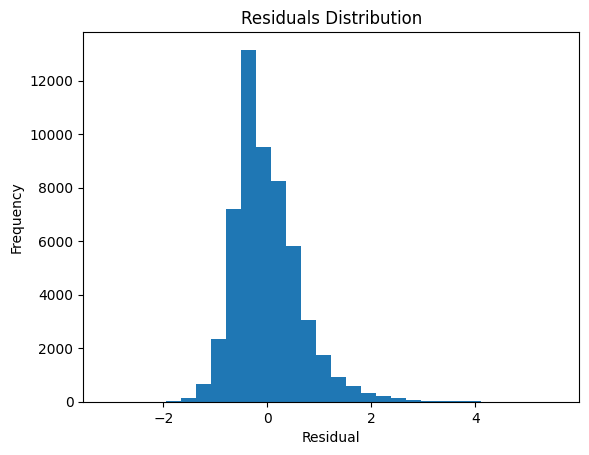

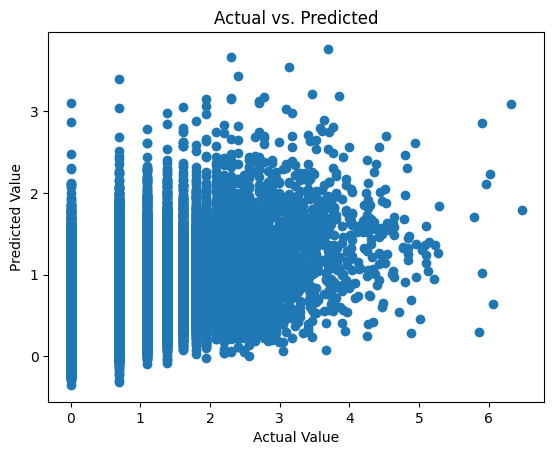


=== Top 10 Largest Errors ===
         y_true    y_pred  residual
9825   5.860786  0.295633  5.565153
358    6.068426  0.648153  5.420272
2549   5.902633  1.025445  4.877189
3317   6.472346  1.787919  4.684427
52742  4.882802  0.287813  4.594989
31748  5.010635  0.463053  4.547582
10251  5.220356  0.942608  4.277747
39526  4.882802  0.692163  4.190639
32934  4.718499  0.541694  4.176805
29817  5.129899  1.052088  4.077810


In [13]:
xgb_evaluator = RegressionEvaluator(y_test, y_pred_test_xgb)
xgb_text,xgb_toperrors = xgb_evaluator.report()

In [55]:
#Preliminarily check which features are relatively important
feature_importances = model.feature_importances_
X_col = list(X.columns)
feature_names = list(X.columns)
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False).reset_index()

print("Feature Importance：")
importance_df.head(20)


Feature Importance：


,index,Feature,Importance
0,23,text_vocab_size,0.086653
1,3,images,0.064081
2,21,text_word_count,0.044697
3,4,verified_purchase,0.030539
4,6,year,0.026470
5,13,verified_purchase_average_rating,0.014651
6,1,rating_number,0.013643
7,7,rating_diff,0.010838
8,11,store_rating_number,0.009751
9,9,brand_rating_number,0.009505


## KNN

=== Regression Metrics ===
                     Value
R2            3.910676e-02
MSE           5.226305e-01
RMSE          7.229319e-01
MAE           5.408457e-01
MedAE         4.210503e-01
MAPE (%)      2.218678e+09
ExplainedVar  3.911212e-02


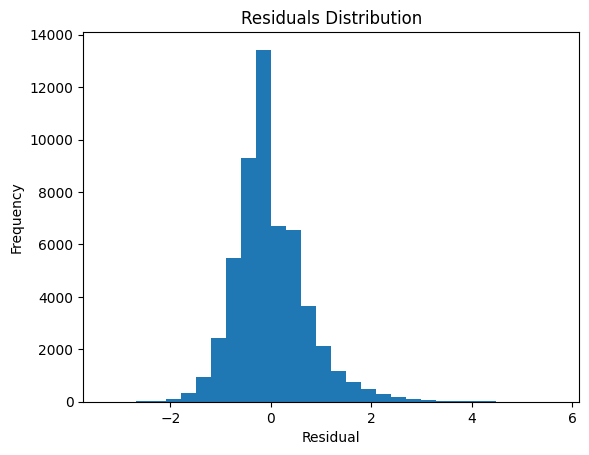

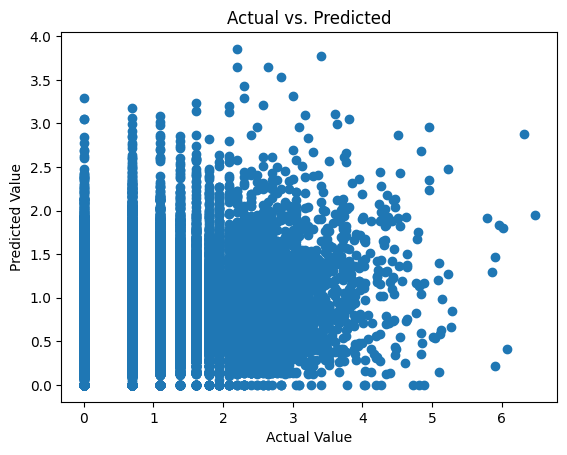


=== Top 10 Largest Errors ===
         y_true    y_pred  residual
2549   5.902633  0.217128  5.685505
358    6.068426  0.410656  5.657769
16055  5.093750  0.145618  4.948132
52742  4.882802  0.000000  4.882802
3848   4.804021  0.000000  4.804021
32934  4.718499  0.000000  4.718499
44483  5.267858  0.669936  4.597922
9825   5.860786  1.301398  4.559388
3317   6.472346  1.946157  4.526189
32371  5.105945  0.587968  4.517978


In [14]:
# 2. K-Nearest Neighbors Regressor
from sklearn.neighbors import KNeighborsRegressor
# drop columns with too many NaNs
X_train_reduced = X_train.drop(['whether_discontinued_review_count', 'whether_discontinued_average_rating'], axis=1)
X_test_reduced  = X_test.drop(['whether_discontinued_review_count', 'whether_discontinued_average_rating'], axis=1)

# Initialize KNN regressor
knn = KNeighborsRegressor(
    n_neighbors=5,       # number of neighbors
    weights='distance',  # weight by inverse distance
    p=2                  # use Euclidean distance
)

# Train the KNN model
knn.fit(X_train_reduced, y_train)

# Predict on the test set
y_pred_knn = knn.predict(X_test_reduced)


knn_evaluator = RegressionEvaluator(y_test, y_pred_knn)
knn_text,knn_toperrors = knn_evaluator.report()

## Multiple Neural Network

In [16]:
# 3. Multi‑Layer Neural Network with PyTorch (including L1 regularization)
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import r2_score

# Convert NumPy arrays to torch tensors
# convert DataFrame → NumPy → tensor
X_train_tensor = torch.tensor(X_train_reduced.to_numpy(), dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.to_numpy(), dtype=torch.float32).view(-1, 1)
X_test_tensor  = torch.tensor(X_test_reduced.to_numpy(),  dtype=torch.float32)
y_test_tensor  = torch.tensor(y_test.to_numpy(),  dtype=torch.float32).view(-1, 1)

# Create DataLoader for batching
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader  = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Define the neural network architecture
class NeuralNetwork(nn.Module):
    def __init__(self, input_dim):
        super(NeuralNetwork, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.LeakyReLU(),    # first hidden activation
            nn.Linear(128, 64),
            nn.ELU(),          # second hidden activation
            nn.Linear(64, 32),
            nn.Tanh(),         # third hidden activation
            nn.Linear(32, 1)   # output layer
        )

    def forward(self, x):
        return self.layers(x)

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize model, loss, optimizer
model_nn   = NeuralNetwork(input_dim=X_train_reduced.shape[1]).to(device)
criterion  = nn.MSELoss()
optimizer  = optim.Adam(model_nn.parameters(), lr=1e-3)
l1_lambda  = 1e-4  # strength of L1 regularization

# Training loop
epochs = 100
for epoch in range(1, epochs + 1):
    model_nn.train()
    running_loss = 0.0

    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)

        # Forward pass
        outputs = model_nn(batch_X)
        mse_loss = criterion(outputs, batch_y)

        # Compute L1 regularization term
        l1_norm = sum(param.abs().sum() for param in model_nn.parameters())
        loss = mse_loss + l1_lambda * l1_norm

        # Backpropagation and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * batch_X.size(0)

    if epoch == 1 or epoch % 10 == 0:
        avg_loss = running_loss / len(train_loader.dataset)
        print(f"Epoch {epoch}/{epochs}, Training Loss: {avg_loss:.4f}")

# Evaluation on the test set
model_nn.eval()
with torch.no_grad():
    y_pred_nn = model_nn(X_test_tensor.to(device)).cpu().numpy().flatten()



/environment/miniconda3/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Epoch 1/100, Training Loss: 0.4921
Epoch 10/100, Training Loss: 0.4446
Epoch 20/100, Training Loss: 0.4428
Epoch 30/100, Training Loss: 0.4427
Epoch 40/100, Training Loss: 0.4428
Epoch 50/100, Training Loss: 0.4423
Epoch 60/100, Training Loss: 0.4423
Epoch 70/100, Training Loss: 0.4417
Epoch 80/100, Training Loss: 0.4420
Epoch 90/100, Training Loss: 0.4419
Epoch 100/100, Training Loss: 0.4417


=== Regression Metrics ===
                     Value
R2            2.016960e-01
MSE           4.341981e-01
RMSE          6.589371e-01
MAE           5.085306e-01
MedAE         4.064586e-01
MAPE (%)      2.294410e+09
ExplainedVar  2.021017e-01


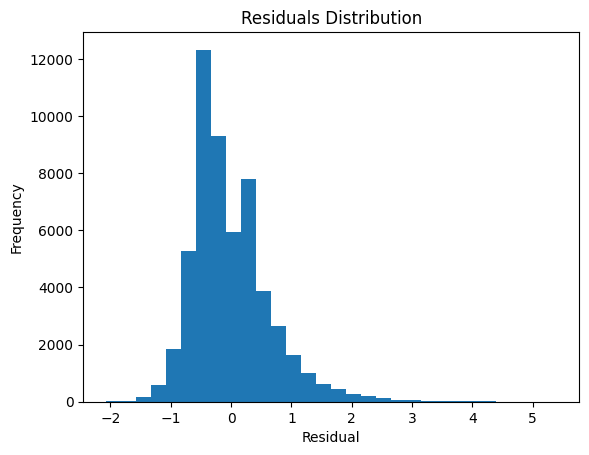

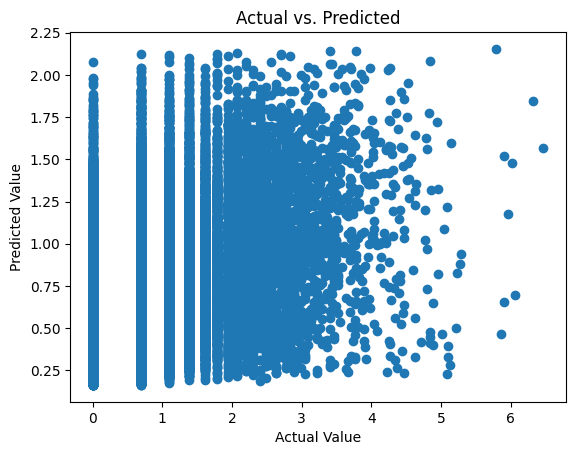


=== Top 10 Largest Errors ===
         y_true    y_pred  residual
9825   5.860786  0.466185  5.394602
358    6.068426  0.697527  5.370898
2549   5.902633  0.654159  5.248474
3317   6.472346  1.566787  4.905560
16055  5.093750  0.229988  4.863762
29817  5.129899  0.278855  4.851044
22640  5.966147  1.178593  4.787554
32371  5.105945  0.329840  4.776106
10251  5.220356  0.502943  4.717412
3545   5.099866  0.394342  4.705525


In [17]:
nn_evaluator = RegressionEvaluator(y_test, y_pred_nn)
nn_text,knn_toperrors = nn_evaluator.report()

# XGBoost with feature selection

Two‑Stage Feature Selection Pipeline

1. **Initial Ranking by XGBoost Gain**  
   Train a full GPU‑accelerated XGBoost model and compute feature importances by average gain. Select the top K features to focus on the most influential predictors.

2. **Refinement via Permutation Importance**  
   Retrain the model using only those top K features, then measure permutation importance on the hold‑out set to assess each feature’s true impact on R². Re‑rank and choose final subsets of size M = [15, 20, 30, 40].

3. **Final Evaluation**  
   For each M, refit a fresh XGBoost model on the reduced feature set and report the test R² to compare how dimensionality reduction affects predictive performance.


In [18]:
import warnings
import logging

# 1) suppress all UserWarning (including XGBoost’s “deprecated” notices)
warnings.filterwarnings('ignore', category=UserWarning)

# 2) silence the xgboost logger entirely
logging.getLogger('xgboost').setLevel(logging.ERROR)

In [20]:
from sklearn.inspection import permutation_importance
from sklearn.metrics import r2_score


# STEP 1: Train a full GPU XGBoost model and pick top‑K by gain importance
full_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    tree_method='gpu_hist',        # use GPU for training
    predictor='gpu_predictor',     # use GPU for prediction
    gpu_id=0,                      # GPU device index
    n_estimators=200,
    max_depth=7,
    learning_rate=0.2,
    random_state=42
)
full_model.fit(X_train, y_train)

# Extract feature‐importance scores (by average gain)
importance_dict = full_model.get_booster().get_score(importance_type='gain')
importance_series = (
    pd.Series(importance_dict)
      .sort_values(ascending=False)
)

# Select the top K features
K = 50
top_k_features = importance_series.iloc[:K].index.tolist()
print(f"Step 1 → Top {K} features by gain:", top_k_features,'\n')

# ──────────────────────────────────────
# STEP 2a: Retrain model on top_k_features
# ──────────────────────────────────────
reduced_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    tree_method='gpu_hist',
    predictor='gpu_predictor',
    gpu_id=0,
    n_estimators=200,
    max_depth=7,
    learning_rate=0.2,
    random_state=42
)
reduced_model.fit(X_train[top_k_features], y_train)

# ──────────────────────────────────────
# STEP 2b: Permutation importance on reduced model
# ──────────────────────────────────────
X_test_k = X_test[top_k_features]  # same columns in same order

perm_result = permutation_importance(
    estimator=reduced_model,
    X=X_test_k,
    y=y_test,
    n_repeats=10,
    random_state=42,
    scoring='r2'
)

# build a Series and sort
perm_importances = (
    pd.Series(perm_result.importances_mean, index=top_k_features)
      .sort_values(ascending=False)
)

# pick your final M features
M_list = [15, 20, 30, 40]
final_features = []
for i,M in enumerate(M_list):
    final_features.append(perm_importances.iloc[:M].index.tolist())
    print(f"Final top {M} by permutation importance:", final_features[-1],'\n')

# ────────────────────────────────────────────────────
# FINAL EVALUATION: Re‐fit and measure performance on the final feature set
# ────────────────────────────────────────────────────
# (Optionally retrain a fresh model on the final subset)
final_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    tree_method='gpu_hist',
    predictor='gpu_predictor',
    gpu_id=0,
    n_estimators=200,
    max_depth=7,
    learning_rate=0.2,
    random_state=42
)
y_preds = {}
for i in range(4):
    final_model.fit(
        X_train[final_features[i]],
        y_train
    )
    key = f"y_pred_final_{M_list[i]}"
    y_preds[key] = final_model.predict(
        X_test_k[final_features[i]]
    )
    r2_final = r2_score(y_test, y_preds[key])
    print(f"R² on test data with final {M_list[i]} features: {r2_final:.4f}")


Step 1 → Top 50 features by gain: ['text_vocab_size', 'images', 'text_word_count', 'verified_purchase', 'year', 'verified_purchase_average_rating', 'rating_number', 'rating_diff', 'store_rating_number', 'brand_rating_number', 'whether_discontinued_review_count', 'whether_discontinued_average_rating', 'store_rating', 'brand_rating', 'f52', 'text_avg_word_length', 'verified_purchase_review_count', 'f60', 'f40', 'f76', 'f120', 'f94', 'f38', 'f101', 'f66', 'f122', 'f112', 'f127', 'f65', 'f102', 'f68', 'f74', 'f117', 'f62', 'f47', 'f39', 'f99', 'f64', 'f73', 'f4', 'f43', 'f5', 'f78', 'f103', 'f105', 'f109', 'f27', 'f124', 'f85', 'f21'] 

Final top 15 by permutation importance: ['year', 'text_vocab_size', 'images', 'rating_number', 'text_word_count', 'store_rating_number', 'verified_purchase', 'store_rating', 'brand_rating_number', 'rating_diff', 'brand_rating', 'whether_discontinued_review_count', 'text_avg_word_length', 'f38', 'f66'] 

Final top 20 by permutation importance: ['year', 'text

=== Regression Metrics ===
                     Value
R2            2.016960e-01
MSE           4.341981e-01
RMSE          6.589371e-01
MAE           5.085306e-01
MedAE         4.064586e-01
MAPE (%)      2.294410e+09
ExplainedVar  2.021017e-01


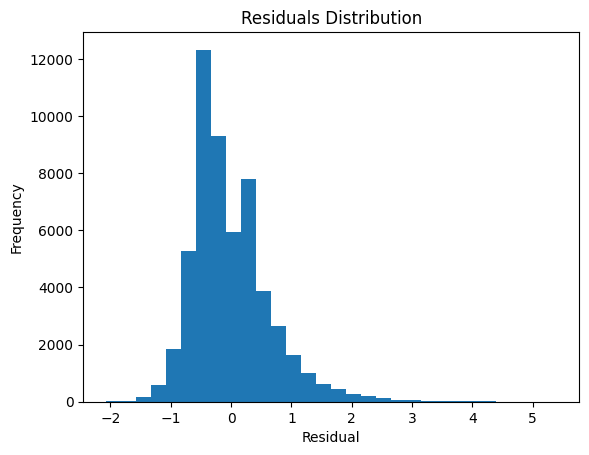

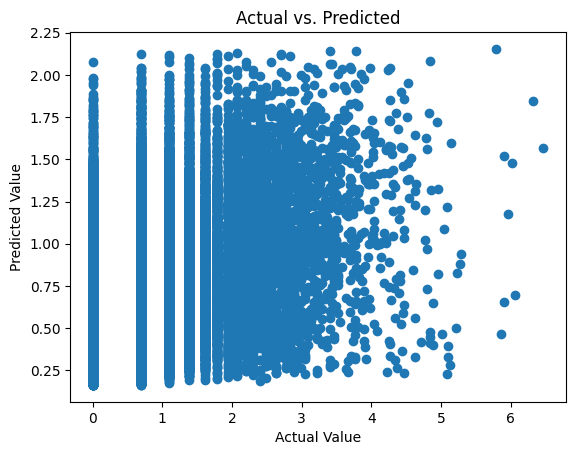


=== Top 10 Largest Errors ===
         y_true    y_pred  residual
9825   5.860786  0.466185  5.394602
358    6.068426  0.697527  5.370898
2549   5.902633  0.654159  5.248474
3317   6.472346  1.566787  4.905560
16055  5.093750  0.229988  4.863762
29817  5.129899  0.278855  4.851044
22640  5.966147  1.178593  4.787554
32371  5.105945  0.329840  4.776106
10251  5.220356  0.502943  4.717412
3545   5.099866  0.394342  4.705525


In [21]:
xgb_sel_evaluator = RegressionEvaluator(y_test, y_preds['y_pred_final_15'])
xgb_sel_text,xgb_sel_toperrors = nn_evaluator.report()

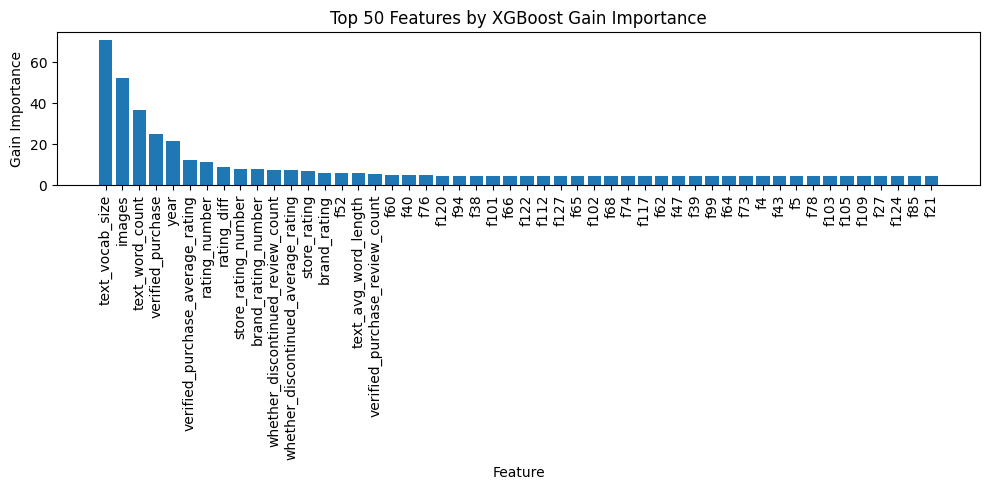

In [22]:
import matplotlib.pyplot as plt

# 1) Plot Top K features by Gain Importance
plt.figure(figsize=(10, 5))
plt.bar(importance_series.index[:K], importance_series.values[:K])
plt.xticks(rotation=90)
plt.title(f"Top {K} Features by XGBoost Gain Importance")
plt.xlabel("Feature")
plt.ylabel("Gain Importance")
plt.tight_layout()
plt.show()



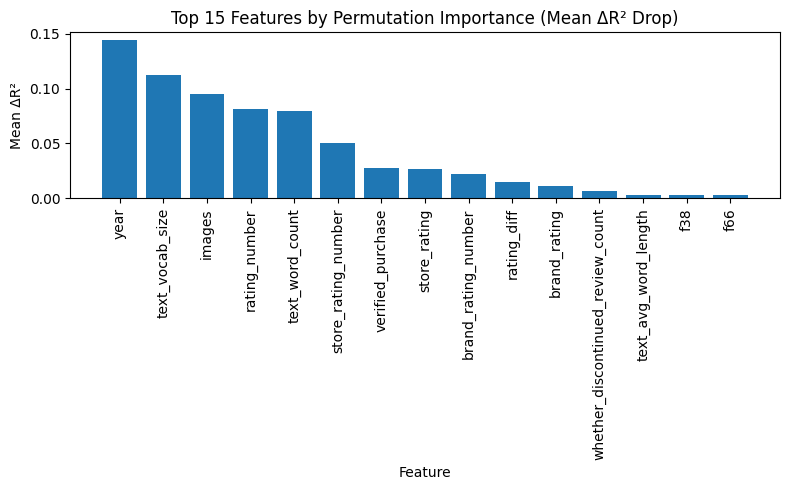

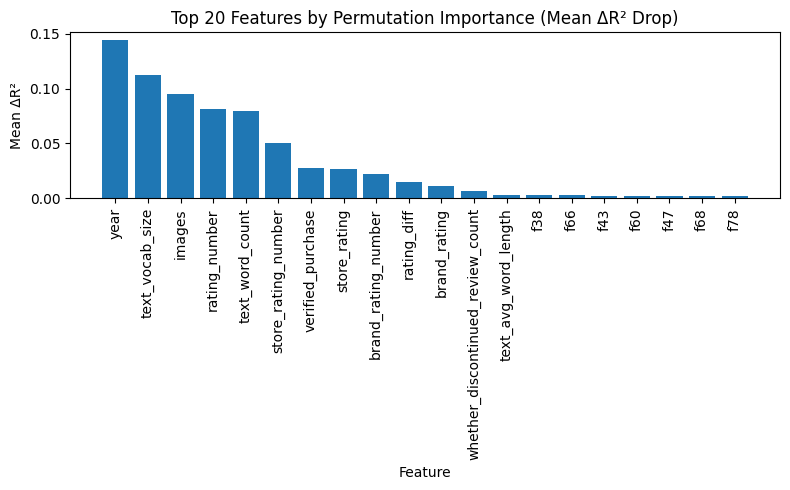

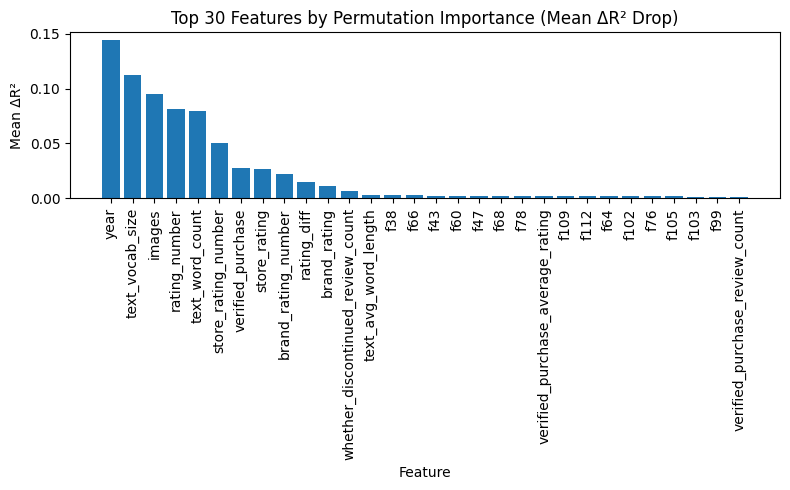

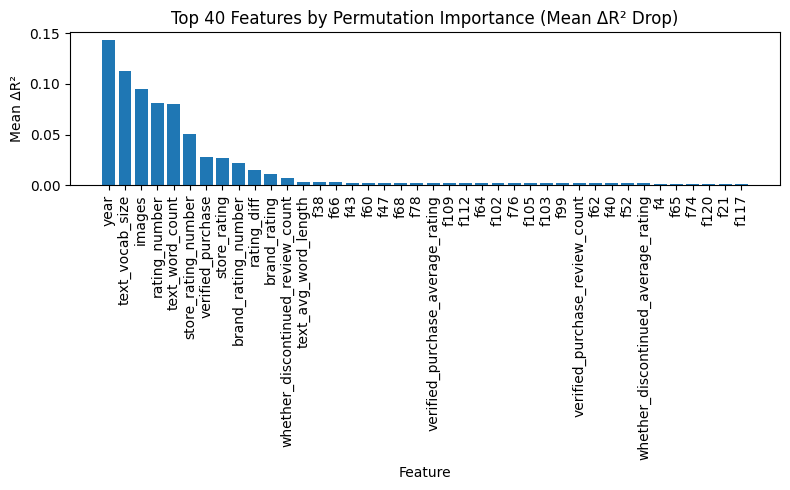

In [23]:
# 2) Plot the top M features by their average ΔR² drop when permuted

M_list = [15, 20, 30, 40]

for M in M_list:
    top_perm = perm_importances.iloc[:M]
    plt.figure(figsize=(8, 5))
    plt.bar(top_perm.index, top_perm.values)
    plt.xticks(rotation=90)
    plt.title(f"Top {M} Features by Permutation Importance (Mean ΔR² Drop)")
    plt.xlabel("Feature")
    plt.ylabel("Mean ΔR²")
    plt.tight_layout()
    plt.show()

## Polynomial Feature Expansion and XGBoost Modeling

Here we expand the selected features into second‑degree interaction terms (excluding the raw discontinued review count), fit an XGBoost regressor on this richer feature set, and evaluate its performance by reporting the test R² score. (Unfortunately this step does not show any positive feedback)


In [24]:
from sklearn.preprocessing import PolynomialFeatures
X_train_selected = X_train[final_features[0]].drop('whether_discontinued_review_count',axis=1)
X_test_selected = X_test[final_features[0]].drop('whether_discontinued_review_count',axis=1)
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_train_poly = poly.fit_transform(X_train_selected)
X_test_poly = poly.transform(X_test_selected)
print(X_train_poly.shape)
poly_feature_names = poly.get_feature_names_out(X_train_selected.columns)
print(poly_feature_names)

(217172, 105)
['year' 'text_vocab_size' 'images' 'rating_number' 'text_word_count'
 'store_rating_number' 'verified_purchase' 'store_rating'
 'brand_rating_number' 'rating_diff' 'brand_rating' 'text_avg_word_length'
 'f38' 'f66' 'year text_vocab_size' 'year images' 'year rating_number'
 'year text_word_count' 'year store_rating_number'
 'year verified_purchase' 'year store_rating' 'year brand_rating_number'
 'year rating_diff' 'year brand_rating' 'year text_avg_word_length'
 'year f38' 'year f66' 'text_vocab_size images'
 'text_vocab_size rating_number' 'text_vocab_size text_word_count'
 'text_vocab_size store_rating_number' 'text_vocab_size verified_purchase'
 'text_vocab_size store_rating' 'text_vocab_size brand_rating_number'
 'text_vocab_size rating_diff' 'text_vocab_size brand_rating'
 'text_vocab_size text_avg_word_length' 'text_vocab_size f38'
 'text_vocab_size f66' 'images rating_number' 'images text_word_count'
 'images store_rating_number' 'images verified_purchase'
 'images 

In [25]:
model = xgb.XGBRegressor(
    objective='reg:squarederror', 
    n_estimators=200, max_depth=7, 
    learning_rate=0.2, subsample=1.0, 
    colsample_bytree=1.0,random_state=42)
model.fit(X_train_poly, y_train)
y_pred_test_poly = model.predict(X_test_poly)
test_r2_poly = r2_score(y_test, y_pred_test_poly)
print("R Square on test data：", test_r2_poly)

R Square on test data： 0.2745031714439392
